# Example use-case: One-zone chemical evolution model.
This use-case example intends to show-case the use of `persistent_data` and accessing previous convolution results.

In some cases it could be useful to keep track of some data in a dictionary that the user can continually update along the convolution. The most relevant thing that comes to mind is a simple one-zone galactic-chemical evolution model where starformation in a closed box can change the general composition of the gas in that box. In that case, one would want to track the composition of stars that form, and how much of that is locked away in compact objects or un-evolving stars, and what the composition is of the material that is returned to the reservoir. Over time, the overall abundance of the reservoir changes.

To be able to do this, we need to keep track of data.

We can do this by utilising the `persistent_data` dictionary that is available in the `post_convolution_hook` when we perform a sequential convolution (as opposed to multiprocessing).

do note: this use-case is really just a closed-box one-zone (ch1.3 of https://edoc.ub.uni-muenchen.de/17111/ Rob Yates' thesis) toy model to provide some rudimentary understanding and build intuition. More sophisticated modeling is can be done with [FlexCE](https://github.com/bretthandrews/flexce)

For 




In this notebook we show how to use chemical yield output from population-synthesis, in this case from `binary_c`, and build a simple GCE model. We compare intermediate results to [Yates, Hendriks, et al 2023](https://academic.oup.com/mnras/article/527/3/6292/7371660) as that study uses similar datasets.


Let us first load some relevant data. We'll use a dataset containing chemical yield of isotopes of a population of stars. 

In [1]:
import copy
import json
import os
import h5py
import pkg_resources

import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt

from syntheticstellarpopconvolve.ensemble_utils import convert_ensemble_to_dataframe
from syntheticstellarpopconvolve.SFR_dict_plotting_routines import load_mpl_rc
from syntheticstellarpopconvolve import convolve, default_convolution_config
from syntheticstellarpopconvolve.general_functions import temp_dir


# load the data
example_ensemble_filename = pkg_resources.resource_filename(
    "syntheticstellarpopconvolve", "example_data/example_ensemble.json"
)
example_ensemble_filename = '/home/david/Desktop/lgalaxies_paper_scripts/binary_c_yields/default/ensembles/binaryStars/ensemble_output-3083cc1f.json'

with open(example_ensemble_filename, "r") as f_ensemble:
    ensemble = json.loads(f_ensemble.read())

This data is stored in the ensemble format, but we will inflate it, convert the isotopes to elements, and select the top 10 of elements.

First lets load the data and make sure it represents what we want it to: the data should be in the unit of mass per unit time (i.e. a normalized yield rate) in this case. 

In [2]:
print(ensemble['metadata']['total_probability_weighted_mass'])

0.7689220857287028


In [3]:
inflated_ensemble = convert_ensemble_to_dataframe(
    ensemble_data=ensemble["ensemble"]['Xyield'],
    verbose=False,
    contains_named_layers=True,
)
inflated_ensemble = inflated_ensemble.astype({'time': 'float', 'probability': 'float'})

inflated_ensemble['normalized_yield'] = inflated_ensemble['probability'] / ensemble['metadata']['total_probability_weighted_mass']
inflated_ensemble = inflated_ensemble[['time', 'source', 'isotope', 'normalized_yield']]

Since the data in this case stored as a number per log10(time), we need to modify the data first a bit and express it in linear time.

In [43]:
# divide by binsizes
from syntheticstellarpopconvolve.general_functions import calculate_bin_edges
import astropy.units as u

# sorted_unique_time_centers = np.sort(inflated_ensemble['time'].unique())
# print(sorted_time_bin_centers)
# time_bin_edges = calculate_bin_edges(sorted_unique_time_centers)

# # turn to linear
# linear_time_bin_edges = 10**time_bin_edges * u.Myr
# linear_time_bin_sizes = np.diff(linear_time_bin_edges).to(u.yr)
# print(linear_time_bin_sizes)

# indices = np.digitize(inflated_ensemble['probability'], time_bin_edges) - 1

# # inflated_ensemble['normalized_yield'] = inflated_ensemble['probability']/linear_time_bin_sizes.value
# inflated_ensemble['normalized_yield'] = inflated_ensemble['probability'] / linear_time_bin_sizes.value[indices]

# print(inflated_ensemble[['normalized_yield', 'probability']])
# inflated_ensemble = inflated_ensemble[['time', 'source', 'isotope', 'normalized_yield']]

[-0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8
  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2
  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2]
[2.90519090e+04 3.65741865e+04 4.60441729e+04 5.79661793e+04
 7.29750961e+04 9.18702029e+04 1.15657733e+05 1.45604459e+05
 1.83305154e+05 2.30767516e+05 2.90519090e+05 3.65741865e+05
 4.60441729e+05 5.79661793e+05 7.29750961e+05 9.18702029e+05
 1.15657733e+06 1.45604459e+06 1.83305154e+06 2.30767516e+06
 2.90519090e+06 3.65741865e+06 4.60441729e+06 5.79661793e+06
 7.29750961e+06 9.18702029e+06 1.15657733e+07 1.45604459e+07
 1.83305154e+07 2.30767516e+07 2.90519090e+07 3.65741865e+07
 4.60441729e+07 5.79661793e+07 7.29750961e+07 9.18702029e+07
 1.15657733e+08 1.45604459e+08 1.83305154e+08 2.30767516e+08
 2.90519090e+08 3.65741865e+08 4.60441729e+08 5.79661793e+08
 7.29750961e+08 9.18702029e+08 1.15657733e+09 1.45604459e+09
 1.

KeyError: 'probability'

Now lets select the unique isotopes and group them by their elements.

In [5]:
unique_isotopes = inflated_ensemble['isotope'].unique()
# print(unique_isotopes)

# remove numbers
cleaned_isotopes = [''.join([i for i in isotope if not i.isdigit()]) for isotope in unique_isotopes] 
unique_elements = np.unique(np.array(cleaned_isotopes))
# print(unique_elements)

# sort on order and reverse to perform groupby
unique_elements = sorted(unique_elements, key=len)[::-1]
print(unique_elements)



#
reduced_inflated_ensemble = inflated_ensemble.copy(deep=True) 
element_df = pd.DataFrame()

# Loop over all elements
for unique_element_i, unique_element in enumerate(unique_elements):
    query = 'isotope.str.startswith("{}")'.format(unique_element)
    # print(query)

    # 
    elements = reduced_inflated_ensemble.query(query)
    elements_mask = reduced_inflated_ensemble.eval(query).to_numpy()
    # print(len(reduced_inflated_ensemble.index))

    # 
    reduced_inflated_ensemble = reduced_inflated_ensemble[np.invert(elements_mask)]
    
    # print(len(reduced_inflated_ensemble.index))
    elements = elements[['time', 'source', 'normalized_yield']]
    grouped = elements.groupby(['time', 'source']).agg({'normalized_yield': 'sum'}).reset_index()
    grouped['element'] = unique_element

    # Combine dataframe again
    element_df = pd.concat([element_df, grouped])






# select elements like in Yates, Hendriks, et al 2023
selected_element_list = ['H', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'S', 'Ca', 'Fe']

# # select which elements have the largest yield (regardless of channel or delay time)
# total_yield_per_element = element_df.groupby(['element']).agg({'probability': 'sum'}).reset_index()
# top_yield_elements = total_yield_per_element.sort_values(by='probability', ascending=False).head(n=10)
# selected_element_list = top_yield_elements['element'].to_list()

# query the main element-df based on the top 10 elements
element_df = element_df.query('element.isin(@selected_element_list)')
print(element_df)

['Zr', 'Zn', 'Yb', 'Xe', 'Tm', 'Tl', 'Ti', 'Te', 'Tc', 'Tb', 'Ta', 'Sr', 'Sn', 'Sm', 'Si', 'Se', 'Sc', 'Sb', 'Ru', 'Rh', 'Re', 'Rb', 'Pt', 'Pr', 'Po', 'Pm', 'Pd', 'Pb', 'Os', 'Ni', 'Ne', 'Nd', 'Nb', 'Na', 'Mo', 'Mn', 'Mg', 'Lu', 'Li', 'La', 'Kr', 'Ir', 'In', 'Ho', 'Hg', 'Hf', 'He', 'Ge', 'Gd', 'Ga', 'Fe', 'Eu', 'Er', 'Dy', 'Cu', 'Cs', 'Cr', 'Co', 'Cl', 'Ce', 'Cd', 'Ca', 'Br', 'Bi', 'Be', 'Ba', 'Au', 'As', 'Ar', 'Al', 'Ag', 'Y', 'W', 'V', 'S', 'P', 'O', 'N', 'K', 'I', 'H', 'F', 'C', 'B']
     time           source  normalized_yield element
0    -0.9             Wind      2.824626e-08      Si
1    -0.8             Wind      3.585835e-08      Si
2    -0.7             Wind      4.555696e-08      Si
3    -0.6             Wind      5.803942e-08      Si
4    -0.5             Wind      7.417973e-08      Si
..    ...              ...               ...     ...
379   4.2             RLOF      6.739562e-12       C
380   4.2            SNAIC      4.012069e-07       C
381   4.2  SNIa_CHAND_Coal     

    time  normalized_yield
0   -0.9          0.003399
1   -0.8          0.003427
2   -0.7          0.003459
3   -0.6          0.003500
4   -0.5          0.003553
5   -0.4          0.003624
6   -0.3          0.003717
7   -0.2          0.003842
8   -0.1          0.004014
9    0.0          0.004254
10   0.1          0.004598
11   0.2          0.005110
12   0.3          0.005903
13   0.4          0.007137
14   0.5          0.008746
15   0.6          0.055880
16   0.7          0.090917
17   0.8          0.085617
18   0.9          0.077823
19   1.0          0.062652
20   1.1          0.042677
21   1.2          0.033583
22   1.3          0.024392
23   1.4          0.019279
24   1.5          0.014415
25   1.6          0.010820
26   1.7          0.008164
27   1.8          0.006366
28   1.9          0.004960
29   2.0          0.003853
30   2.1          0.003005
31   2.2          0.002370
32   2.3          0.001826
33   2.4          0.001404
34   2.5          0.001090
35   2.6          0.000843
3

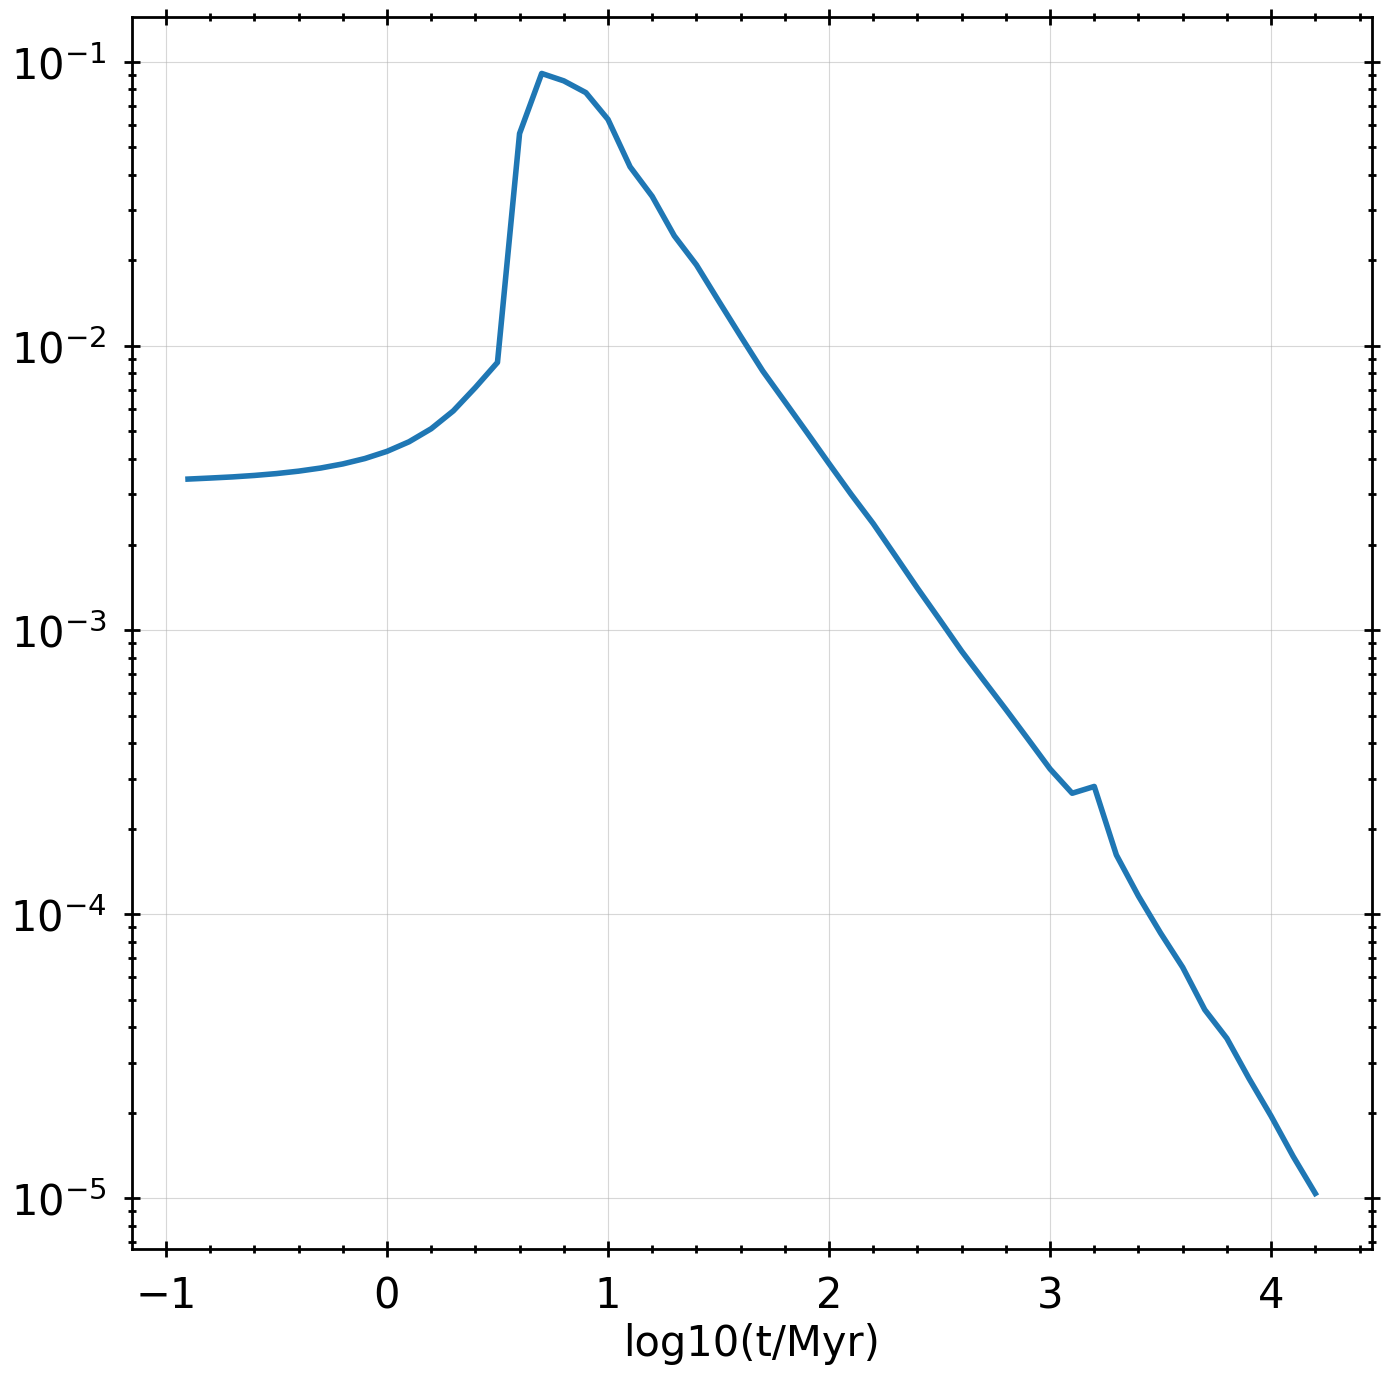

In [6]:
# lets plot some data and compare it to yates 2023
sum_per_timebin = element_df.groupby(['time']).agg({'normalized_yield': 'sum'}).reset_index()

# turn into linear time.
sum_per_timebin['normalized_yield'] = sum_per_timebin['normalized_yield'] / (10**sum_per_timebin['time'].to_numpy()) * np.log(10)
# print(sum_per_timebin)

# 
load_mpl_rc()
fig, ax = plt.subplots()

ax.plot(sum_per_timebin['time'], sum_per_timebin['normalized_yield'])
ax.set_yscale('log')
ax.set_xlabel('log10(t/Myr)')

print(sum_per_timebin)

In [29]:
sum_per_timebin['linear_time'] = 10**sum_per_timebin['time']

#
current_time = 0.2 * u.Myr
linear_times = sum_per_timebin['linear_time'].to_numpy() * u.Myr
rates = sum_per_timebin['normalized_yield'].to_numpy() * (u.Msun/u.Myr)
total_yield = 0 * u.Msun
print('linear_times', linear_times)

timestep = 0.1 * u.Myr
while current_time < 14 * u.Gyr:

    current_timebin = np.digitize(np.array([current_time.to(u.yr).value]), linear_times.to(u.yr).value)-1
    current_rate = rates[current_timebin[0]]

    current_yield = current_rate * timestep
    total_yield += current_yield    
    current_time += timestep

print(total_yield)

linear_times [1.25892541e-01 1.58489319e-01 1.99526231e-01 2.51188643e-01
 3.16227766e-01 3.98107171e-01 5.01187234e-01 6.30957344e-01
 7.94328235e-01 1.00000000e+00 1.25892541e+00 1.58489319e+00
 1.99526231e+00 2.51188643e+00 3.16227766e+00 3.98107171e+00
 5.01187234e+00 6.30957344e+00 7.94328235e+00 1.00000000e+01
 1.25892541e+01 1.58489319e+01 1.99526231e+01 2.51188643e+01
 3.16227766e+01 3.98107171e+01 5.01187234e+01 6.30957344e+01
 7.94328235e+01 1.00000000e+02 1.25892541e+02 1.58489319e+02
 1.99526231e+02 2.51188643e+02 3.16227766e+02 3.98107171e+02
 5.01187234e+02 6.30957344e+02 7.94328235e+02 1.00000000e+03
 1.25892541e+03 1.58489319e+03 1.99526231e+03 2.51188643e+03
 3.16227766e+03 3.98107171e+03 5.01187234e+03 6.30957344e+03
 7.94328235e+03 1.00000000e+04 1.25892541e+04 1.58489319e+04] Myr
3.47227468074716 solMass


In [2]:
records = [{"a": 2, "b": 3, "normalized_yield": 1, "time": 1}]
dummy_df = pd.DataFrame.from_records(records)
TMP_DIR = temp_dir("code", "persistent_data", clean_path=True)


def post_convolution_function(
    config,
    sfr_dict,
    data_dict,
    convolution_results,
    convolution_instruction,
    persistent_data,
    previous_convolution_results,
):
    """
    Post-convolution function to handle integrating the systems forward in time and finding those that end up in the LISA waveband.

    using local_indices to select everything and using Alexey's distance sampler to handle sampling the distances
    """

    print(persistent_data)
    print(previous_convolution_results)

    if "test" not in persistent_data:
        persistent_data["test"] = 0
    persistent_data["test"] += 1

    return convolution_results


##################
#

# create file
output_hdf5_filename = os.path.join(TMP_DIR, "output_hdf5.h5")
generate_boilerplate_outputfile(output_hdf5_filename)

# store the data frame in the hdf5file
dummy_df.to_hdf(input_hdf5_filename, key="input_data/events/example")


#
convolution_config = copy.copy(default_convolution_config)
convolution_config["output_filename"] = output_hdf5_filename
convolution_config["tmp_dir"] = TMP_DIR
convolution_config["multiprocessing"] = False


###
# convolution instructions
convolution_config["convolution_instructions"] = [
    {
        "convolution_type": "integrate",
        "input_data_name": "example",
        "output_data_name": "example",
        "filter_future_events": False,
        "post_convolution_function": post_convolution_function,
        "data_column_dict": {
            # required
            "normalized_yield": "normalized_yield",
            "delay_time": {"column_name": "time", "unit": u.Myr},
        },
    },
]

#
convolution_config["convolution_lookback_time_bin_edges"] = np.arange(0, 6, 1) * u.Gyr

# construct the sfr-dict (NOTE: this uses absolute SFR, not metallicity dependent)
scale = 1e-5
convolution_config["SFR_info"] = {
    'lookback_time_bin_edges': (np.arange(0, 10, 1) * u.Gyr).to(u.yr),
    'starformation_rate_array': scale * np.ones(9) * u.Msun / u.yr    
}

[convolve_events.py:39 - convolve_events_by_integration_post_convolution_hook_wrapper ] 2025-01-15 17:06:34,123: Handling post-convolution function hook call for convolve-events by integration


{}
None


[convolve_populations.py:113 - store_convolution_result_entries ] 2025-01-15 17:06:34,133: Storing yield
[convolve_populations.py:113 - store_convolution_result_entries ] 2025-01-15 17:06:34,135: Storing test
[convolve_events.py:39 - convolve_events_by_integration_post_convolution_hook_wrapper ] 2025-01-15 17:06:34,138: Handling post-convolution function hook call for convolve-events by integration


{'test': 1}
{'convolution_results': {'yield': <Quantity [1.e-05] 1 / yr>}}


[convolve_populations.py:113 - store_convolution_result_entries ] 2025-01-15 17:06:34,170: Storing yield
[convolve_populations.py:113 - store_convolution_result_entries ] 2025-01-15 17:06:34,175: Storing test
[convolve_events.py:39 - convolve_events_by_integration_post_convolution_hook_wrapper ] 2025-01-15 17:06:34,183: Handling post-convolution function hook call for convolve-events by integration


{'test': 2}
{'convolution_results': {'yield': <Quantity [1.e-05] 1 / yr>}}


[convolve_populations.py:113 - store_convolution_result_entries ] 2025-01-15 17:06:34,213: Storing yield
[convolve_populations.py:113 - store_convolution_result_entries ] 2025-01-15 17:06:34,217: Storing test
[convolve_events.py:39 - convolve_events_by_integration_post_convolution_hook_wrapper ] 2025-01-15 17:06:34,223: Handling post-convolution function hook call for convolve-events by integration


{'test': 3}
{'convolution_results': {'yield': <Quantity [1.e-05] 1 / yr>}}


[convolve_populations.py:113 - store_convolution_result_entries ] 2025-01-15 17:06:34,247: Storing yield
[convolve_populations.py:113 - store_convolution_result_entries ] 2025-01-15 17:06:34,251: Storing test
[convolve_events.py:39 - convolve_events_by_integration_post_convolution_hook_wrapper ] 2025-01-15 17:06:34,260: Handling post-convolution function hook call for convolve-events by integration


{'test': 4}
{'convolution_results': {'yield': <Quantity [1.e-05] 1 / yr>}}


[convolve_populations.py:113 - store_convolution_result_entries ] 2025-01-15 17:06:34,280: Storing yield
[convolve_populations.py:113 - store_convolution_result_entries ] 2025-01-15 17:06:34,282: Storing test


finished convolution
<KeysViewHDF5 ['config', 'input_data', 'output_data']>
<KeysViewHDF5 ['event']>
<KeysViewHDF5 ['example']>
<KeysViewHDF5 ['example']>
<KeysViewHDF5 ['convolution_results']>
<KeysViewHDF5 ['0.5 Gyr', '1.5 Gyr', '2.5 Gyr', '3.5 Gyr', '4.5 Gyr']>
<KeysViewHDF5 ['test', 'yield']>


In [ ]:
# convolve
convolve(config=convolution_config)

print("finished convolution")

In [ ]:
# read out content and integrate until today
with h5py.File(convolution_config["output_filename"], "r") as output_hdf5_file:

    print(output_hdf5_file.keys())
    print(output_hdf5_file["output_data"].keys())
    print(output_hdf5_file["output_data/event"].keys())
    print(output_hdf5_file["output_data/event/example"].keys())
    print(output_hdf5_file["output_data/event/example/example"].keys())
    print(
        output_hdf5_file["output_data/event/example/example/convolution_results"].keys()
    )
    print(
        output_hdf5_file[
            "output_data/event/example/example/convolution_results/0.5 Gyr"
        ].keys()
    )

## Further ideas
This example is a rather simple setup. Its a single box without any inflow and outflow, stars form at a fixed metallicity and they form following a prescribed star formation rate. 

Real life, of course, is somewhat more complicated. Among other processes, the ejecta and outflows of the stars will impact the metallicity and rate at which the next set of stars form. Inflow and outflow will change the reservoir abundance as well. 